<a href="https://colab.research.google.com/github/indrawanth/Car_Detection_using_R-CNN/blob/main/CAR_DETECTION_USING_R_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CAR DETECTION USING FAST R-CNN

2502481043

INDRAWAN HADIANTO

In [ ]:
!pip install torch torchvision torchaudio
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import zipfile
import os

zip_path = "/Cruise Control Car Detection.v3-data-sudah-di-split-training.coco.zip"
extract_path = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Berhasil diekstrak ke:", extract_path)


Berhasil diekstrak ke: /content


In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import json
import os
from PIL import Image

class CocoDetectionFasterRCNN(Dataset):
    def __init__(self, img_folder, annotation_file, transforms=None):
        self.img_folder = img_folder
        self.transforms = transforms

        with open(annotation_file) as f:
            coco = json.load(f)

        self.images = coco['images']
        self.annotations = coco['annotations']
        self.categories = coco['categories']

        # Buat mapping id -> annotations
        self.image_id_to_ann = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.image_id_to_ann:
                self.image_id_to_ann[img_id] = []
            self.image_id_to_ann[img_id].append(ann)

        self.image_id_to_file = {img['id']: img['file_name'] for img in self.images}

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.img_folder, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        anns = self.image_id_to_ann.get(img_id, [])
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Path dataset kamu
train_dataset = CocoDetectionFasterRCNN(
    img_folder="/content/train",
    annotation_file="/content/train/_annotations.coco.json",
    transforms=T.ToTensor()
)

val_dataset = CocoDetectionFasterRCNN(
    img_folder="/content/valid",
    annotation_file="/content/valid/_annotations.coco.json",
    transforms=T.ToTensor()
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(train_dataset.categories) + 1  #background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 191MB/s]


In [ ]:
import torch
import torchvision
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 29.6968
Epoch 2, Loss: 24.9960
Epoch 3, Loss: 22.0585
Epoch 4, Loss: 18.4560
Epoch 5, Loss: 16.4048
Epoch 6, Loss: 14.7633
Epoch 7, Loss: 14.6551
Epoch 8, Loss: 13.1840
Epoch 9, Loss: 12.2784
Epoch 10, Loss: 11.5105


In [ ]:
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)
        # predition
        print(outputs[0])
        break


{'boxes': tensor([[340.6400, 284.2273, 448.1826, 360.0000],
        [375.0911, 227.2364, 507.4196, 311.5769],
        [182.6796, 229.6014, 347.4720, 355.0006],
        [336.8625, 235.4282, 379.7004, 271.7979],
        [522.9209, 239.9533, 640.0000, 319.6346],
        [125.3742, 315.9729, 183.8156, 360.0000],
        [  1.3240, 270.2217, 161.2240, 315.8966],
        [175.2492, 233.4745, 214.7965, 272.5741],
        [500.8889, 298.1053, 628.0876, 331.7026],
        [484.9106, 238.2458, 515.0069, 282.5727],
        [509.8304, 248.4489, 635.4147, 330.6360]], device='cuda:0'), 'labels': tensor([2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2], device='cuda:0'), 'scores': tensor([0.9991, 0.9990, 0.9986, 0.9977, 0.9975, 0.9973, 0.9965, 0.9963, 0.8693,
        0.0668, 0.0643], device='cuda:0')}


In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameter       : {total_params:,}")
print(f"Trainable parameter   : {trainable_params:,}")


Total parameter       : 41,314,536
Trainable parameter   : 41,092,136


In [ ]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F

def plot_prediction(image, prediction, score_threshold=0.5, label_map=None):
    image = F.to_pil_image(image.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    boxes = prediction['boxes'].cpu()
    scores = prediction['scores'].cpu()
    labels = prediction['labels'].cpu()

    for box, score, label in zip(boxes, scores, labels):
        if score < score_threshold:
            continue

        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        color = 'lime'
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        label_str = label_map[label.item()] if label_map else str(label.item())
        text = f"{label_str}: {score:.2f}"
        ax.text(x1, y1 - 5, text, color=color, fontsize=12, weight='bold', backgroundcolor='black')

    plt.axis('off')
    plt.show()


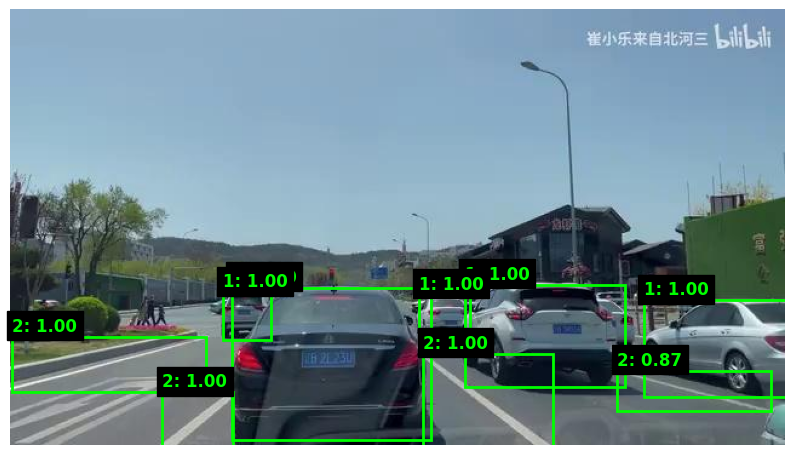

In [ ]:
model.eval()
image, target = val_dataset[0]  # ambil 1 sample dari validation
with torch.no_grad():
    prediction = model([image.to(device)])[0]

plot_prediction(image, prediction, score_threshold=0.5)


In [ ]:
!pip install torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        # Update metrics
        metric.update(outputs, targets)

# Hasil evaluasi
result = metric.compute()
print(result)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.9 MB/s eta 0:00:00
{'map': tensor(0.7198), 'map_50': tensor(0.9121), 'map_75': tensor(0.8544), 'map_small': tensor(0.5628), 'map_medium': tensor(0.7688), 'map_large': tensor(0.8074), 'mar_1': tensor(0.2692), 'mar_10': tensor(0.7799), 'mar_100': tensor(0.7799), 'mar_small': tensor(0.6670), 'mar_medium': tensor(0.8183), 'mar_large': tensor(0.8402), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}
